# 1. Set up

## 1.1 Environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from IPython.display import display

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import sklearn
import re

import statsmodels.api as sm 
import seaborn as sns
sns.set_style('whitegrid')

from __future__ import division
from math import *
from scipy import integrate
from numpy import inf
from sklearn import mixture, neighbors 

from windrose import WindroseAxes, WindAxes

from helpers.utility_helper import *
from helpers.app_helper import *
from helpers.gmm_helper import *
from helpers.plot_helper import *
from helpers.data_reader import *

## 1.2 Read Data

In [2]:
# ipath = './data/NCDC/ciampino/6240476818161dat.txt'
# ipath = './data/NCDC/boscombe_down/3466726903106dat.txt'
# ipath = './data/NCDC/tiree.txt'
ipath= "./data/NCDC/marham.txt"

# ipath= "./data/NCDC/narrandera/dat.txt" 
# ipath= "./data/NCDC/melita_man/dat.txt" 
# ipath= "./data/NCDC/vatry/dat.txt"  # double peak?
# ipath= "./data/NCDC/avord/dat.txt" 

# ipath= './data/NCDC/tenerife_sur/5894676958432dat.txt'  # lack initial speed
# ipath= "./data/NCDC/huspel_aws/7901916962788dat.txt"  
# ipath= "./data/NCDC/auckland/4774046962787dat.txt" 
# ipath= "./data/NCDC/brisbane/dat.txt" 
# ipath= "./data/NCDC/brisbane_archerfield/dat.txt" 

# ipath= "./data/NCDC/diepholz/dat.txt" # recent year is integer
# ipath= "./data/NCDC/wuxu/dat.txt" 

## Bad dataset
# ipath= "./data/NCDC/gushi/dat.txt" # data is too little
# ipath= "./data/NCDC/yueyang/dat.txt" # data is too little

# ipath= "./data/NCDC/sacramento_arp/dat.txt"  # truancate data
# ipath= "./data/NCDC/medicine_lodge/dat.txt"  # data not complete, especially recent year
# ipath= "./data/NCDC/st_louis_arp/9511346969491dat.txt"  truncate
## US dataset, is mostly over a threshold, low wind speed is not complete
# ipath= './data/NCDC/huron/3461896967321dat.txt'
# ipath= "./data/NCDC/baltimore/9963956959409dat.txt"
# ipath= './data/NCDC/kennedy/5807936958436dat.txt'
# ipath= './data/NCDC/newark/8455636958433dat.txt'
# ipath= './data/NCDC/la_guardia/1057036958434dat.txt'
# ipath= "./data/NCDC/olympia_airport/2647036962786dat.txt" # dataset has some problem, speed not complete
# ipath= "./data/NCDC/carlos_ibanez/9844226962789dat.txt" # problem dataset, lack beginning of speed
# ipath= "./data/NCDC/sidney/6062326959357dat.txt" 

# ipath= './data/NCDC/macau/8518316959352dat.txt'
# ipath= "./data/NCDC/上海/虹桥/9705626661750dat.txt"
# ipath= "./data/NCDC/南京lukou/7271776959346dat.txt"
# ipath= "./data/NCDC/武汉tianhe/5855286959350dat.txt"
# ipath= "./data/NCDC/长沙huanghua/8169756959349dat.txt"
# ipath= "./data/NCDC/郑州xinzheng/7934376661728dat.txt"

# ipath= "./data/cn_database/beijing.txt"
# ipath= "./data/cn_database/xiamen.txt"
# ipath= "./data/cn_database/hefei.txt"
# ipath= "./data/cn_database/lasa.txt"
# ipath= "./data/cn_database/lenghu.txt"

uipath = unicode(ipath , "utf8")
cn_database = False

if not "cn_database" in ipath: 
    df = pd.read_csv(uipath,header=0, skipinitialspace=True)
    df.rename(columns={'Date':'date','Dir':'dir','Spd':'speed','Type':'type'}, inplace=True)
    df = df[['date','HrMn','type','dir','speed' ]]
else:
    df = read_cn_database(uipath)
    cn_database = True

In [3]:
# select year 1945-2014, dir < 999, speed<999
df = df.query("(dir < 999) & (speed < 999) & \
              (date >= 19800000) & (date < 20160000) & \
              (HrMn % 5 == 0 )")

# Turn dir into [0,360), some station are[10,360],some are [0,350]
df['dir'] = df['dir'].apply(lambda x: x%360)
df.index= df['date']
df.describe()

,date,HrMn,dir,speed
count,447243.000000,447243.000000,447243.000000,447243.000000
mean,19998783.907153,1168.281851,184.857391,4.739733
std,101492.086192,688.968703,93.912703,2.699617
min,19800101.000000,0.000000,0.000000,0.500000
25%,19910701.000000,600.000000,120.000000,2.600000
50%,20020116.000000,1200.000000,200.000000,4.100000
75%,20090227.000000,1750.000000,250.000000,6.200000
max,20150801.000000,2355.000000,350.000000,28.000000


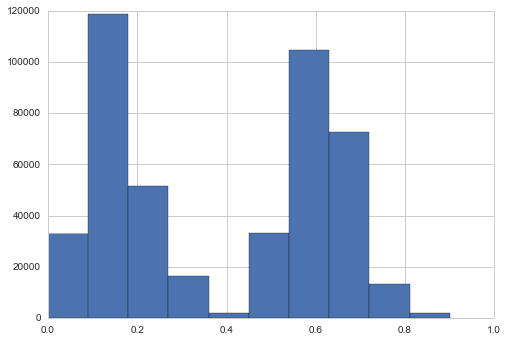

In [4]:
# Detect data stored in knot or m/s
df['decimal'] = df.speed % 1 
df.decimal.hist()
knot_unit = True if len(df.query('decimal >= 0.2'))/len(df) > 0.3 else False

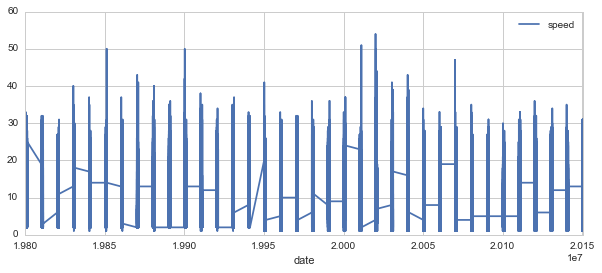

In [5]:
# Using speed unit in knot instead of m/s
# need more elaboration, some is not near an integer
if knot_unit:
    df.rename(columns={'speed':'speed_mps'}, inplace=True)
    df['speed']=df['speed_mps']
    df['speed']=df['speed_mps']*1.943845
    df['speed']=df['speed'].apply(lambda x: int(round(x)))

df['speed'].plot(legend=True,figsize=(10,4), grid=True)

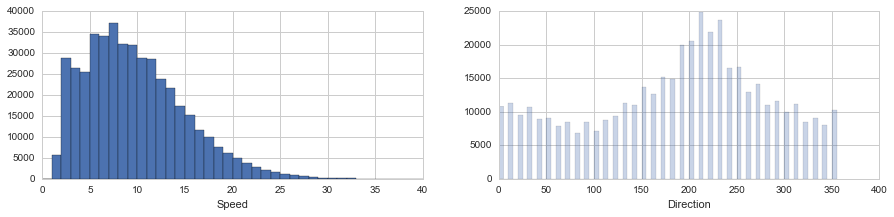

In [6]:
# Notice the gap of the distributions, so futher process needed, as below
plot_speed_and_angle_distribution(df)

## 1.3 Data Wrangling

### 1.3.1 Artefacts handling

,date,HrMn,type,dir,speed_mps,decimal,speed,incre,incre_reverse
date,,,,,,,,,
20020128,20020128,1700,FM-12,240,28.0,0.0,54,26,27
20011228,20011228,1400,FM-12,280,26.0,0.0,51,25,30
20020304,20020304,50,FM-15,40,25.7,0.7,50,44,46
19851113,19851113,900,FM-12,220,25.7,0.7,50,40,45
19900223,19900223,1000,SY-MT,290,25.7,0.7,50,43,45
20070118,20070118,1250,FM-15,270,24.2,0.2,47,17,0
20070118,20070118,1300,FM-12,270,24.2,0.2,47,0,12
20021027,20021027,1000,FM-12,250,22.6,0.6,44,10,32
20070118,20070118,1500,FM-12,270,22.1,0.1,43,0,3


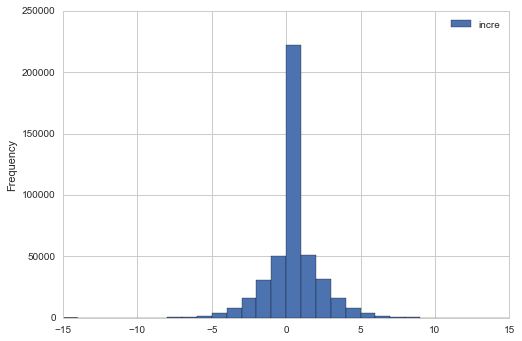

In [7]:
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0)
display(df.sort_values(by='speed',ascending=False).head(10))
bins=np.arange(-15, 15 + 1, 1)
df['incre'].plot(kind='hist', bins=bins, legend=True)

In [8]:
# Simple Artefacts Handling
incre_threshold = 20 if knot_unit else 10
df = df.query('(incre < @incre_threshold )&(incre_reverse < @incre_threshold )')
df = df.query('dir % 10 <= 0.1')

After Simple Aretefacts Handling

In [9]:
# Check the max speed
df.sort_values(by='speed',ascending=False).head(10)

,date,HrMn,type,dir,speed_mps,decimal,speed,incre,incre_reverse
date,,,,,,,,,
20070118,20070118,1250,FM-15,270,24.2,0.2,47,17,0
20070118,20070118,1300,FM-12,270,24.2,0.2,47,0,12
20070118,20070118,1450,FM-15,270,22.1,0.1,43,8,0
20070118,20070118,1500,FM-12,270,22.1,0.1,43,0,3
20040320,20040320,1600,FM-12,250,22.1,0.1,43,3,8
19900226,19900226,700,FM-12,230,22.1,0.1,43,9,18
19870327,19870327,1400,SY-MT,220,22.1,0.1,43,7,3
19900125,19900125,1650,FM-15,250,21.6,0.6,42,3,0
19900125,19900125,1700,SY-MT,250,21.6,0.6,42,0,4


### 1.3.2 Sampling Time Selection

In [10]:
df['HrMn'].value_counts().sort_index()

0       12102
5           3
10          3
15          1
20          5
25          2
30         10
35          1
50       6107
55          1
100     12155
105         1
110         1
120         5
130         3
135         2
150      6212
155         1
200     12123
205         2
220         8
225         1
230         9
240         1
245         2
250      6289
255         2
300     12025
310         3
315         1
        ...  
2045        2
2050     6117
2100    12177
2105        1
2110        2
2115        4
2120        3
2125        1
2130        5
2140        2
2145        2
2150     6111
2155        1
2200    12213
2205        1
2210        1
2220        5
2225        2
2230        2
2235        1
2250     6217
2300    12242
2305        2
2315        1
2320        8
2325        2
2330        9
2345        2
2350     6318
2355        5
Name: HrMn, dtype: int64

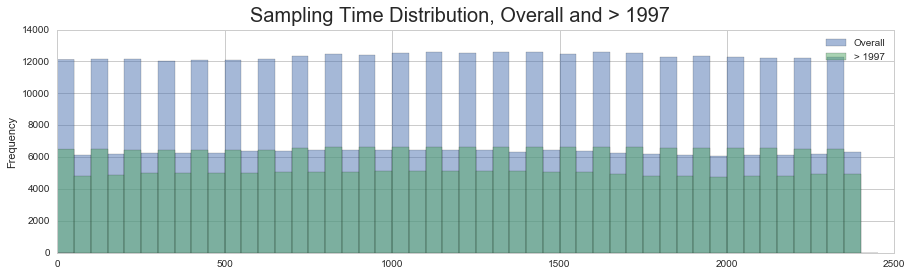

In [11]:
# Ensure data sampled equally
mid_year = int(((min(df.date)+max(df.date))/2 )/10000)
bins=np.arange(min(df.HrMn), max(df.HrMn) + 100, 50)

df['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='Overall')

df.query('date > @mid_year * 10000')['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' %  mid_year )

plt.suptitle('Sampling Time Distribution, Overall and > %s ' %  mid_year, fontsize = 20)
plt.legend()

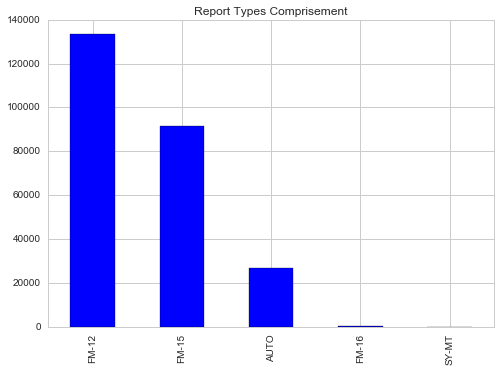

In [12]:
df.query("date >= 20000000 ")['type'].value_counts().plot(
    kind = 'bar', title = 'Report Types Comprisement')

report_type_most_used = df.query("date >= 20000000 ")['type'].value_counts().argmax()

In [13]:
# Data Selection
if "ciampino" in ipath: 
    df = df[(df['HrMn'] % 100 == 15)|(df['HrMn'] % 100 == 45)|(df['HrMn'] % 100 == 20)|(df['HrMn'] % 100 == 50)]
else: 
    df = df.query('HrMn % 5 <= 0.1')

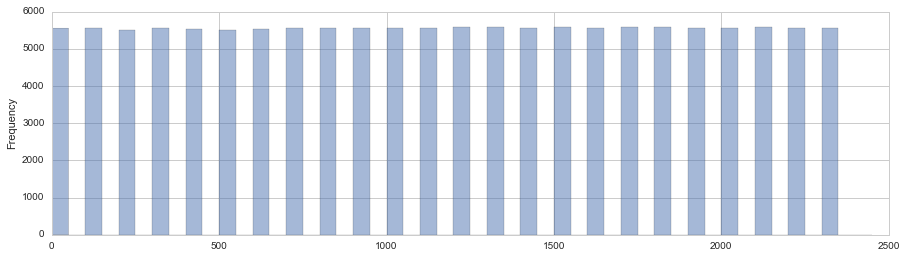

In [14]:
# We're gonna use the most frequent report type, here is its distirbution
df = df.query("type==@report_type_most_used")

df.query('date > 20000000')['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins)

## 1.3.3 Time Shift Comparison

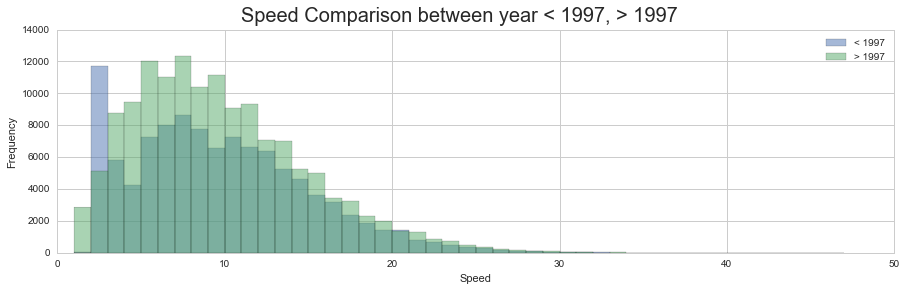

In [15]:
mid_year = int(((min(df.date)+max(df.date))/2 )/10000)

# Comparison between mid_year, looking for: 
# 1. Odd Even Bias
# 2. Time Shift of Wind Speed Distribution
bins = np.arange(min(df.speed), max(df.speed) + 1, 1)
df[df['date'] < mid_year * 10000]['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='< %s' % mid_year)

df[df['date'] > mid_year * 10000]['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' % mid_year)

plt.xlabel("Speed")
plt.suptitle('Speed Comparison between year < %s, > %s ' % (mid_year, mid_year), fontsize = 20)
plt.legend()

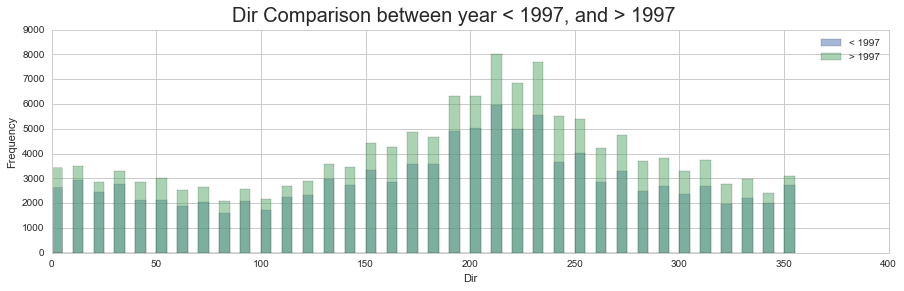

In [16]:
bins=np.arange(min(df.dir), max(df.dir) + 10, 5)
df[df['date'] < mid_year * 10000]['dir'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='< %s' % mid_year)

df[df['date'] > mid_year * 10000]['dir'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' % mid_year)

plt.xlabel("Dir")
plt.suptitle('Dir Comparison between year < %s, and > %s ' % (mid_year, mid_year), fontsize = 20)
plt.legend()

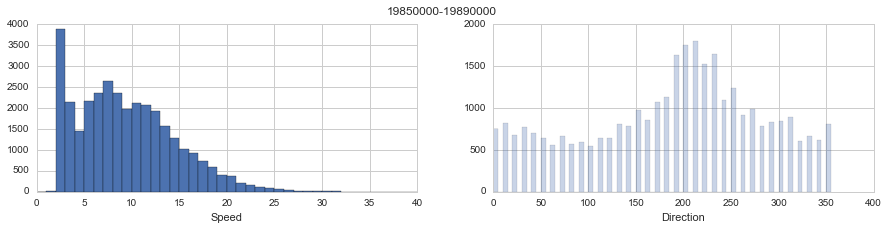

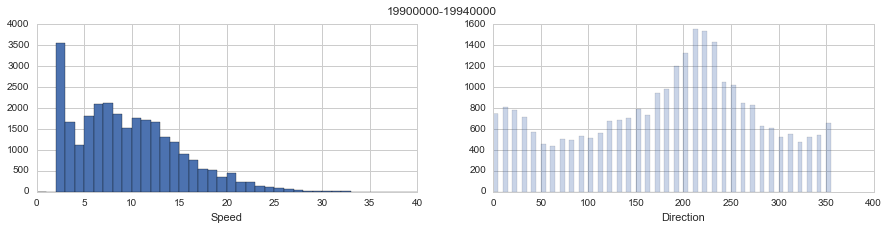

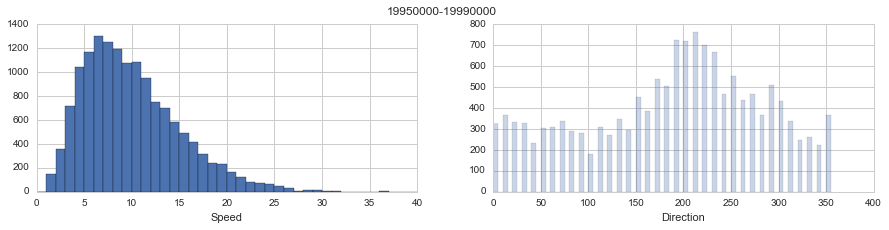

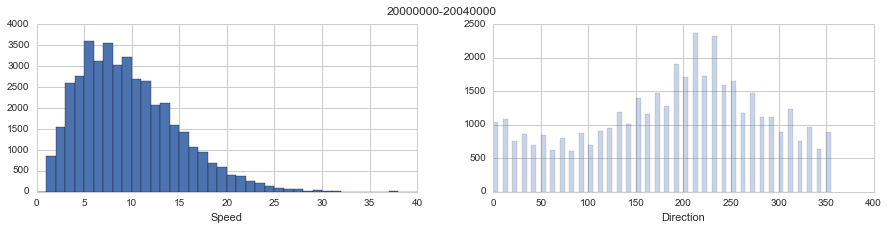

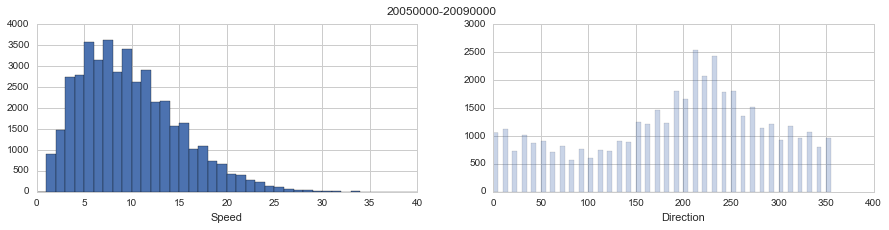

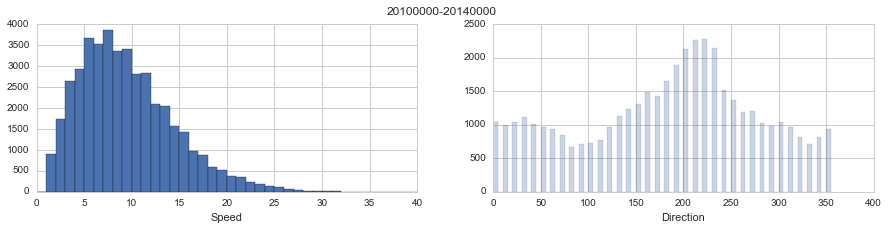

In [17]:
# Inspect the time shift of speed and degree distribution, and odd-even bias
def check_time_shift(df):
    for start_time in xrange(19850000, 20150000, 50000):
        end_time = start_time + 50000 
        sub_df = df.query('(date >= @start_time) & (date < @end_time)')
        if len(sub_df) > 0 :
            title = str(start_time) +'-' + str(end_time-10000)
            plot_speed_and_angle_distribution(sub_df, title)
        
check_time_shift(df)

## 1.4 Re-select data, data conversion, and overview of the clean dataset

In [18]:
# Year range, Reports Type, Sampling Time
df = df.query('(date >= 20050000) & (date < 20150000)')
df.describe()

,date,HrMn,dir,speed_mps,decimal,speed,incre,incre_reverse
count,86357.000000,86357.000000,86357.000000,86357.000000,86357.000000,86357.000000,86357.000000,86357.000000
mean,20095838.424227,1150.951284,185.304260,4.700727,0.399964,9.139259,-0.000880,-0.001853
std,28674.512619,691.893854,94.270048,2.621236,0.260613,5.093984,0.377403,2.140605
min,20050101.000000,0.000000,0.000000,0.500000,0.000000,1.000000,-16.000000,-18.000000
25%,20070712.000000,600.000000,120.000000,2.600000,0.100000,5.000000,0.000000,-1.000000
50%,20100110.000000,1200.000000,200.000000,4.100000,0.500000,8.000000,0.000000,0.000000
75%,20120704.000000,1800.000000,250.000000,6.200000,0.600000,12.000000,0.000000,1.000000
max,20141231.000000,2300.000000,350.000000,24.200000,0.900000,47.000000,10.000000,16.000000


### 1.4.1 Overview

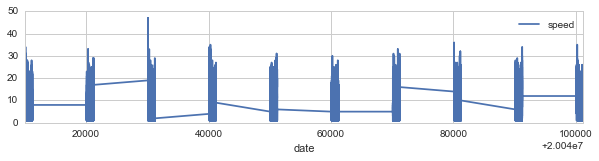

In [19]:
df['speed'].plot(legend=True,figsize=(10,2), grid=True)

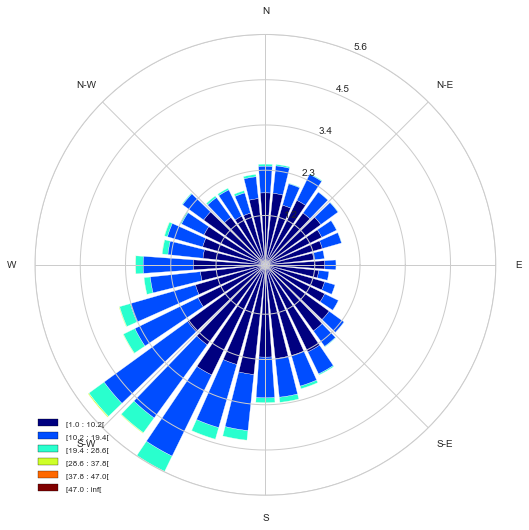

In [20]:
df.dir_windrose = df.dir
# 90 degree is in east
ax = WindroseAxes.from_ax()
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36)
ax.set_legend()

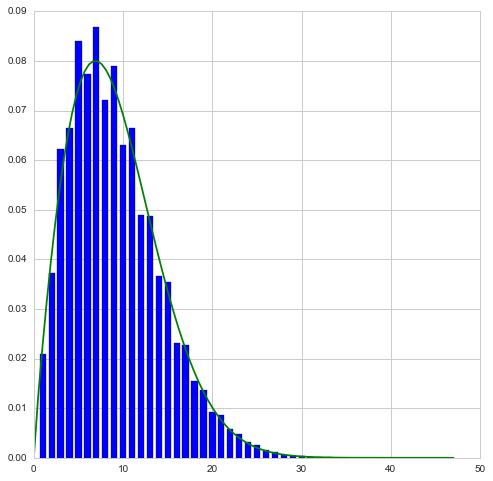

In [21]:
ax = WindAxes.from_ax()
bins=np.arange(min(df.speed), max(df.speed) + 1, 1)
ax, params = ax.pdf(df.speed, bins = bins)

In [22]:
print params
weibull_params = sp.stats.exponweib.fit(df.speed, floc=0, f0=1)
print weibull_params

(1, 1.8812186272261244, 0, 10.313480956145394)
(1, 1.8812186272261244, 0, 10.313480956145394)


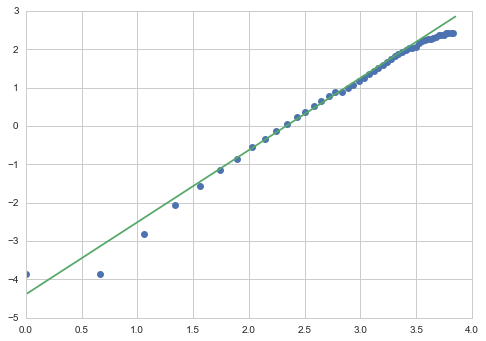

In [23]:
sample = df.speed
ecdf = sm.distributions.ECDF(sample)

x = np.linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(np.log(x), np.log(-np.log(1-y)),'o')

x = np.linspace(min(sample), max(sample))
w_scale, c_shape = weibull_params[1], weibull_params[3]
qz=np.exp(-(x/c_shape)**w_scale)
plt.plot(np.log(x), np.log(-np.log(qz)),'-')
plt.show()

### 1.4.2 Direction Conversion, from windrose to polar system
e.g. 0 degree = north, clockwise => 90 degree = north, counterclockwise

In [24]:
df['dir'] = df['dir'].apply(lambda x: (90 - x)%360)

In [25]:
df['dir'].value_counts().sort_index()

0      1480
10     1242
20     1662
30     1661
40     1887
50     1888
60     2124
70     1778
80     2113
90     2108
100    1903
110    1616
120    1785
130    1784
140    2159
150    1981
160    2202
170    2177
180    2725
190    2556
200    3187
210    3316
220    4588
230    4357
240    4821
250    3799
260    3692
270    2889
280    2897
290    2699
300    2565
310    2123
320    2038
330    1701
340    1518
350    1336
Name: dir, dtype: int64

In [26]:
if cn_database:
    # cn_database, the angle is not evenly distributed, so there is a need to redistribute
    original_angle = [0, 20, 50, 70, 90,
                     110, 130, 160, 180,
                     200, 230, 250, 270,
                     290, 310, 340]
    redistributed_angle = np.linspace(0,360,num=17)[:-1]
    df['dir'].replace(to_replace=original_angle, value=redistributed_angle, inplace=True)
    df['dir'].value_counts().sort_index()

In [27]:
df.describe()

,date,HrMn,dir,speed_mps,decimal,speed,incre,incre_reverse
count,86357.000000,86357.000000,86357.000000,86357.000000,86357.000000,86357.000000,86357.000000,86357.000000
mean,20095838.424227,1150.951284,189.896013,4.700727,0.399964,9.139259,-0.000880,-0.001853
std,28674.512619,691.893854,93.050479,2.621236,0.260613,5.093984,0.377403,2.140605
min,20050101.000000,0.000000,0.000000,0.500000,0.000000,1.000000,-16.000000,-18.000000
25%,20070712.000000,600.000000,120.000000,2.600000,0.100000,5.000000,0.000000,-1.000000
50%,20100110.000000,1200.000000,210.000000,4.100000,0.500000,8.000000,0.000000,0.000000
75%,20120704.000000,1800.000000,260.000000,6.200000,0.600000,12.000000,0.000000,1.000000
max,20141231.000000,2300.000000,350.000000,24.200000,0.900000,47.000000,10.000000,16.000000


### 1.4.3 Re-distribute Direction, within each sector (optional)
e.g. Dir 50 -> -45 ~ 55, to make KDE result better

In [28]:
sector_length = 10 if not cn_database else 22.5

def randomize_angle(df, sector_length = 10):
    df['dir_ran'] = df['dir'].apply(lambda x: (x + np.random.uniform(-sector_length/2,sector_length/2))% 360)

    bins=np.arange(0, 360+10, 5)
    df['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    bins=np.arange(0, 360+10, 1)
    df['dir_ran'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    
    df['dir']=df['dir_ran']
    df.drop(['dir_ran'], 1,inplace=True)
    return df

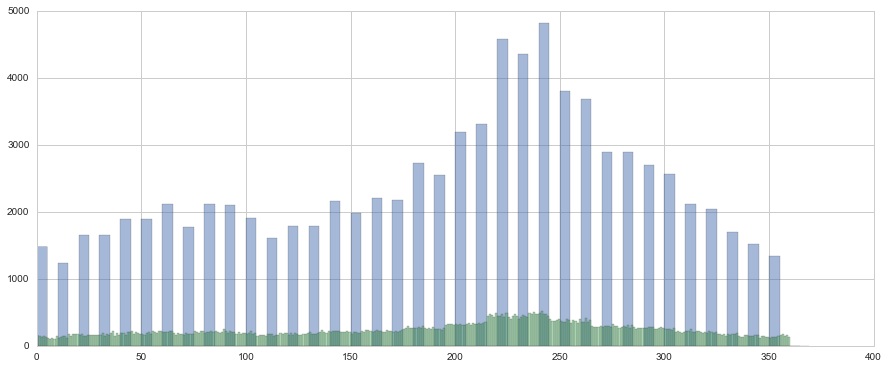

In [29]:
# Randomize the angle degree, to form a better KDE estimation
df['dir_int'] = df['dir']
df = randomize_angle(df, sector_length)

In [30]:
def randomize_speed(df):
    df['speed_ran'] = df['speed'].apply(lambda x: (x + np.random.uniform(-1,0)))

    bins=np.arange(0, df.speed.max(), 1)
    df['speed'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    bins=np.arange(0, df.speed.max(), 0.5)
    df['speed_ran'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    
    df['speed']=df['speed_ran']
    df.drop(['speed_ran'], 1,inplace=True)
    return df

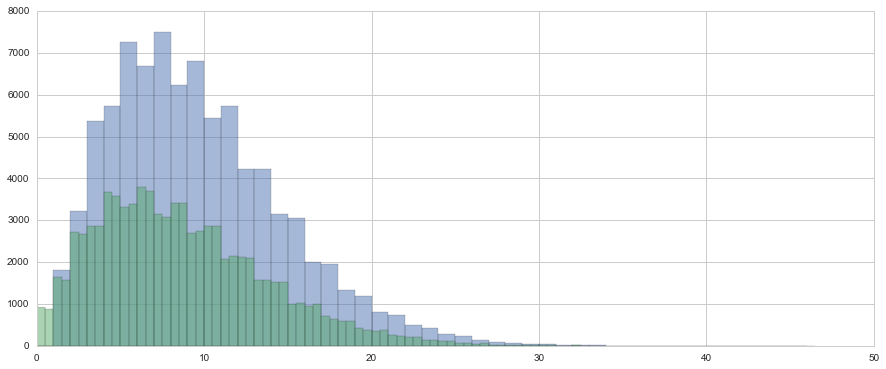

In [31]:
# Each original cell is split between the value, # so the peak is shift left
# e.g. 2 -> (1.5,2), (2,2.5); or 3 -> (2,3)
df['speed_int'] = df['speed']
df = randomize_speed(df)

### 1.4.4 Generate (x,y) from (speed,dir)

-2.0505075955 -1.76149097403


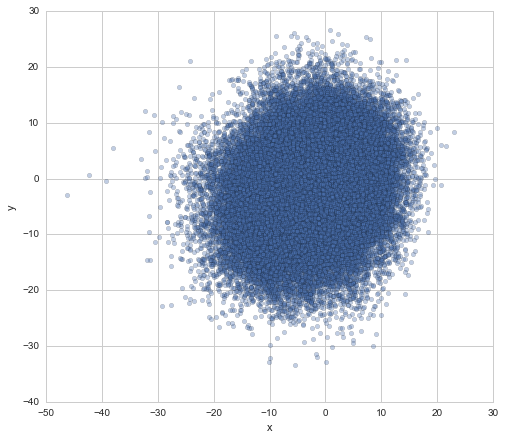

In [32]:
df['x'] = df['speed'] * np.cos(df['dir'] * np.pi / 180.0)
df['y'] = df['speed'] * np.sin(df['dir'] * np.pi / 180.0)
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
ax.set_aspect('equal')
df.plot(kind='scatter', x='x', y='y', alpha=0.35, ax=ax)
print np.mean(df.x), np.mean(df.y)

# 2. Create input data, i.e. speed_set

In [33]:
# speed_set = np.array(zip(-df.x, -df.y)) # Adjust the direction to match for Cook's paper
speed_set = np.array(zip(df.x, df.y))
speed_angle_set = np.array(zip(df.speed, df.dir))
max_speed = df.speed.max()
number_of_gaussian = 3

In [34]:
fitting_range = []
if knot_unit == True:
    fitting_axis_range = np.arange(-20, 21, 1)
    plot_axis_range = np.arange(-25, 25, 1)
else:
    fitting_axis_range = np.arange(-10, 11, 1)
    plot_axis_range = np.arange(-10, 11, 1)
    
for i in fitting_axis_range:
    for j in fitting_axis_range:
        fitting_range.append([i,j])

original_dim = int(np.sqrt(len(fitting_range))) 

# 3. Kernel Density Estimation

In [35]:
sample = speed_set

In [36]:
# # The bandwidth value would be too radical, so we forsake this approach
# from sklearn.grid_search import GridSearchCV
# grid = GridSearchCV(neighbors.KernelDensity(),
#                     {'bandwidth': np.linspace(0.1, 1.0, 15)},
#                     n_jobs=-1, cv=4) 
# grid.fit(sample)
# print grid.best_params_
# kde = grid.best_estimator_

In [37]:
bandwidth = 1 if knot_unit else 0.5  # for wuhan, 0.4 is better
kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample)

points = fitting_range
# very slow if the dataset is too large, e.g. 100,000
# kde returns log prob, need to convert it
kde_result = np.exp(kde.score_samples(points))
print kde_result[:5]
print len(kde_result)

[  1.85438084e-05   2.34213784e-05   2.76060826e-05   3.71527410e-05
   5.20387599e-05]
1681


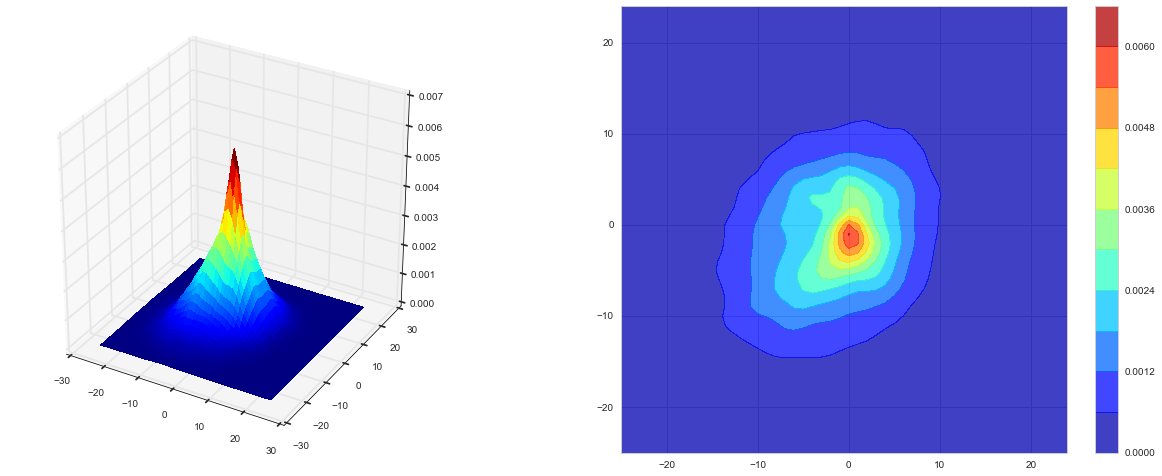

In [38]:
# Plot jPDF
X = Y = plot_axis_range
# Can't work if pass as generate_Z_from_X_Y(X,Y, np.exp(kde.score_samples())), need to use lambda
# see http://stackoverflow.com/questions/21035437/passing-a-function-as-an-argument-in-python
kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: np.exp(kde.score_samples(coords)))

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,kde_Z,ax2)

In [39]:
kde_cdf = cdf_from_pdf(kde_result)

# 4. GMM Estimation, using EM algo

In [40]:
sample= speed_set
clf = mixture.GMM(n_components=number_of_gaussian, covariance_type='full')
clf.fit(sample)

clf.converged_

True

In [41]:
gmm_em_result = read_gmm_em_result(clf, print_result = False)
pretty_print_gmm(gmm_em_result)  

,weight,mean_x,mean_y,sig_x,sig_y,corr
0,0.375224,0.939918,-2.911226,4.867612,5.763262,0.200190
1,0.326290,-0.900650,2.891870,5.773681,5.942542,0.047447
2,0.298486,-7.066717,-5.403003,6.469861,6.919234,0.029674


GMM Plot Result
0.326290432765 [[-0.90064984  2.89187035]] [ 5.69382952  6.01909501] 150.642502044
0.298485676921 [[-7.06671676 -5.40300282]] [ 6.44816761  6.93945517] 168.087495945
0.375223890314 [[ 0.93991767 -2.91122627]] [ 4.59260802  5.98471241] 155.144216011


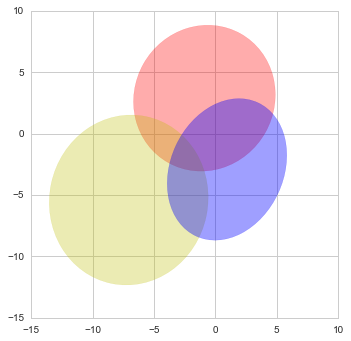

In [42]:
plot_gmm_ellipses(gmm_em_result)

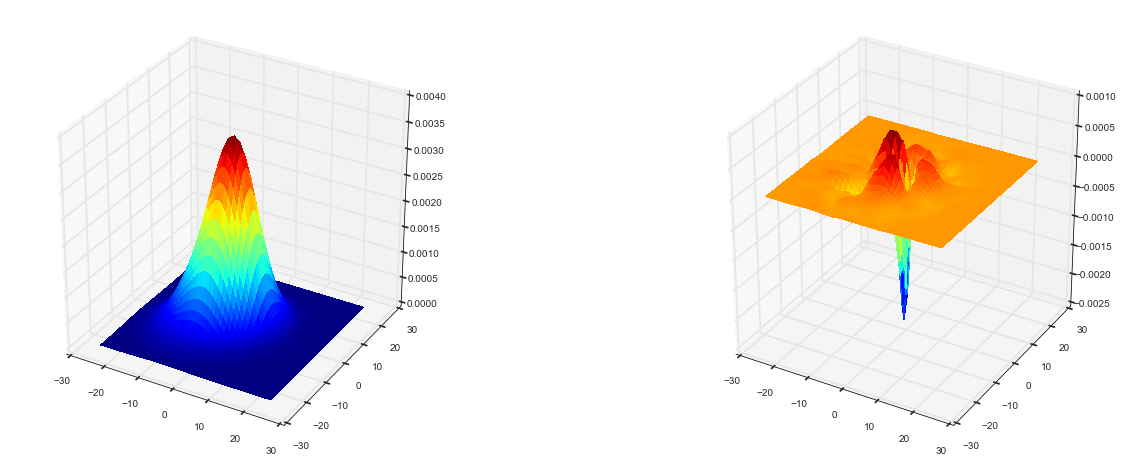

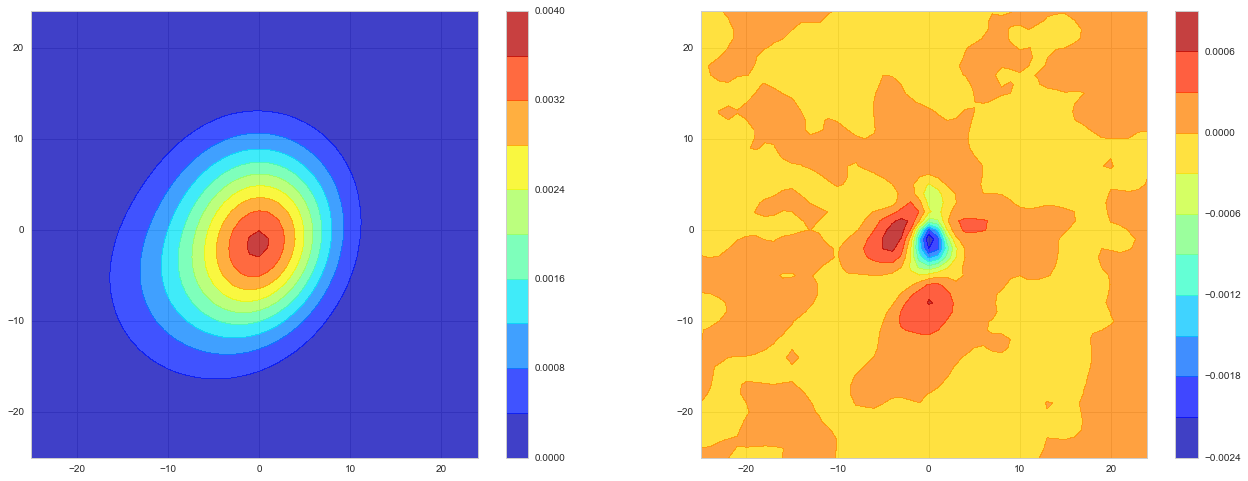

In [43]:
X = Y = plot_axis_range
pdf_Z = generate_Z_from_X_Y(X,Y, lambda coords: np.exp(clf.score_samples(coords)[0]))

def residule_between_kde_and_gmm(points):
    kde_vals = np.exp(kde.score_samples(points))
    gmm_vals = np.exp(clf.score_samples(points)[0])
    return gmm_vals - kde_vals

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)
gmm_em_3d_fig = fig

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1)
plot_2d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,residual_Z,ax2)
gmm_em_2d_fig = fig

## GMM, EM VS. KDE

In [44]:
points = fitting_range
gmm_pdf_result = np.exp(clf.score_samples(points)[0])

In [45]:
# put into Pandas to make it looks better
pd.DataFrame([goodness_of_fit_summary(gmm_pdf_result, kde_result, count = len(df))])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,2437.942944,0.013456,3.536574e-08,0.031149,0.320544,0.954597


# 5. Least Square Prob Estimation

In [46]:
sample = speed_set
points = fitting_range

In [47]:
gmm_em_result = read_gmm_em_result(clf, print_result = False)
pretty_print_gmm(gmm_em_result)             

,weight,mean_x,mean_y,sig_x,sig_y,corr
0,0.375224,0.939918,-2.911226,4.867612,5.763262,0.200190
1,0.326290,-0.900650,2.891870,5.773681,5.942542,0.047447
2,0.298486,-7.066717,-5.403003,6.469861,6.919234,0.029674


In [48]:
count = len(df)
def GMM_fit_score(gmm, kde_result, method = 'square_error'): 
    # 1. Create the GMM PDF
    if not isinstance(gmm[0], np.ndarray):
        gmm = group_gmm_param_from_gmm_param_array(gmm, sort_group = False)
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    # 2. Fit the model using different metrics
    gmm_pdf_result = mixed_model_pdf(points)
    if method == 'square_error':
        # 2.1 Square error
        error_array = np.power(gmm_pdf_result - kde_result,2)
        result = mse_log = np.log(np.average(error_array))
    elif method == 'chi_square':
        # 2.2 Chi square
        error_array = np.power(gmm_pdf_result - kde_result,2)
        # unable to * count = 43412
        result = chi_square_stat = sum(error_array/gmm_pdf_result) 
    elif method == 'K_S':
        # 2.3 K-S statistc
        gmm_cdf = cdf_from_pdf(gmm_pdf_result)
        diff = np.absolute(gmm_cdf - kde_cdf)
        result = KS_stat = np.amax(diff)
    return result

# from GMM,EM 
# GMM format: weight, meanx, meany, sigx, sigy, rho
x0 = gmm_em_result

cons = [
    # sum of every 6th element, which is the fraction of each gaussian
    {'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
    # limit the width/height ratio of elliplse, optional
#     {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
#     {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
]

bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)

result = sp.optimize.minimize(
    lambda x0: GMM_fit_score(x0, kde_result),
    x0,
    bounds = bonds,
    constraints=cons,
    tol = 0.000000000001,
    options = {"maxiter": 500})
result

     fun: -18.558947406964737
     jac: array([  8.46821308e-01,   2.38418579e-07,   2.38418579e-07,
         0.00000000e+00,   2.38418579e-07,  -2.38418579e-06,
         8.46813202e-01,   4.76837158e-07,  -2.38418579e-07,
         0.00000000e+00,   2.38418579e-07,   1.19209290e-06,
         8.46842289e-01,   2.38418579e-07,  -4.76837158e-07,
        -1.90734863e-06,  -2.38418579e-07,   4.76837158e-07,
         0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 1345
     nit: 66
    njev: 66
  status: 0
 success: True
       x: array([ 0.45583155,  1.83473076, -0.58766762,  4.78781991,  6.46989381,
        0.1029017 ,  0.49164833, -5.92128421, -3.03790485,  5.84957398,
        7.98117655,  0.18379304,  0.05252013,  0.2792633 , -1.70478086,
        1.41362002,  2.16748289,  0.134469  ])

## LRMSE VS. KDE

In [49]:
kde_result[:5]

array([  1.85438084e-05,   2.34213784e-05,   2.76060826e-05,
         3.71527410e-05,   5.20387599e-05])

In [50]:
gmm = group_gmm_param_from_gmm_param_array(result.x, sort_group = True)
mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
gmm_pdf_result = mixed_model_pdf(points)

pretty_print_gmm(gmm)

,weight,mean_x,mean_y,sig_x,sig_y,corr
0,0.491648,-5.921284,-3.037905,5.849574,7.981177,0.183793
1,0.455832,1.834731,-0.587668,4.787820,6.469894,0.102902
2,0.052520,0.279263,-1.704781,1.413620,2.167483,0.134469


GMM Plot Result
0.491648328188 [[-5.92128421 -3.03790485]] [ 5.64818374  8.12494402] 164.898139466
0.455831545073 [[ 1.83473076 -0.58766762]] [ 4.73297541  6.51012206] 170.696825704
0.0525201267391 [[ 0.2792633  -1.70478086]] [ 1.39170462  2.1816191 ] 171.513042836


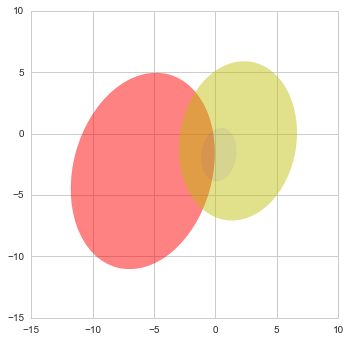

In [51]:
plot_gmm_ellipses(gmm)

## Goodness-of-fit indicators

In [52]:
pd.DataFrame(
    [goodness_of_fit_summary(gmm_pdf_result, kde_result, count = len(df))])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,1144.475222,0.012367,8.708664e-09,0.015457,0.159064,0.98882


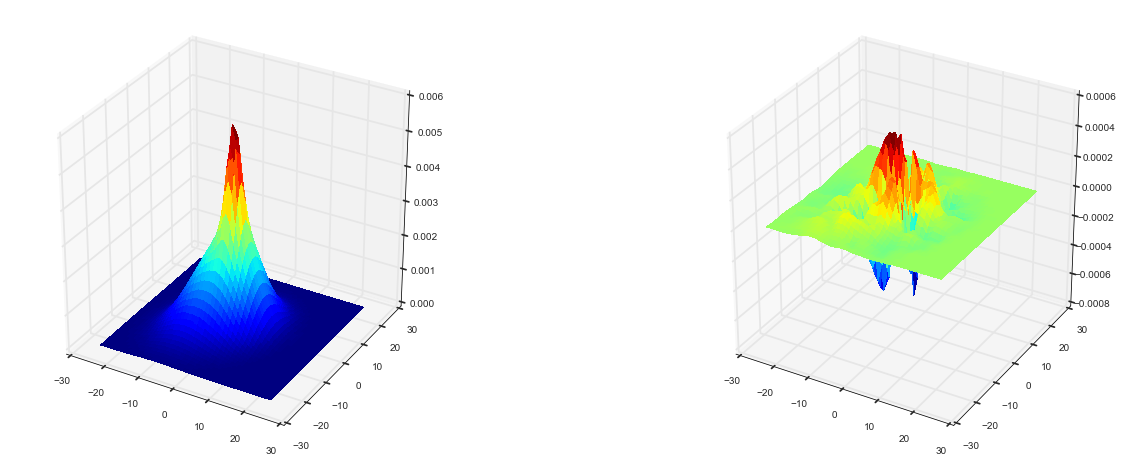

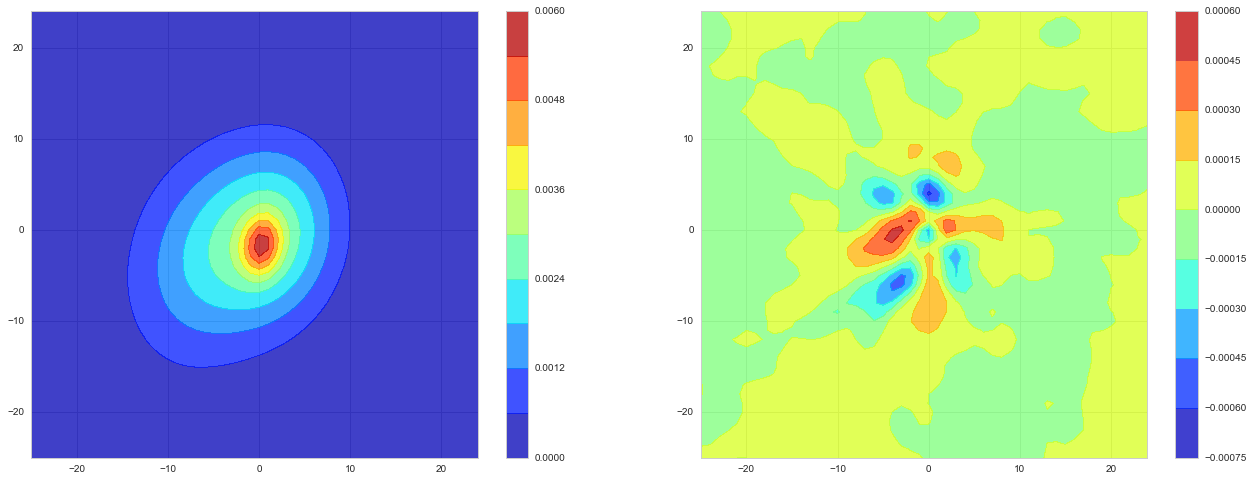

In [53]:
X = Y = plot_axis_range
pdf_Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument

def residule_between_kde_and_gmm(points):
    kde_vals = np.exp(kde.score_samples(points))
    gmm_vals = mixed_model_pdf(points)
    return gmm_vals - kde_vals

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1)
plot_2d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,residual_Z,ax2)

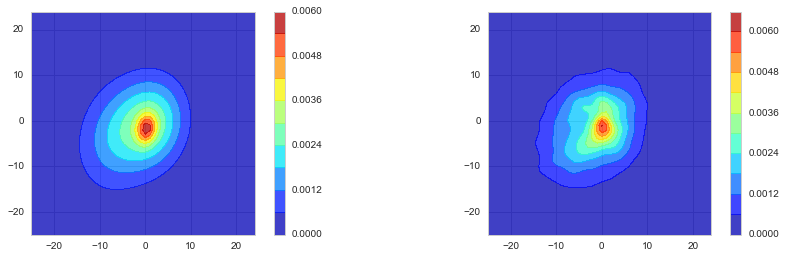

In [54]:
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1,2,1)
plot_2d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,kde_Z,ax2)

In [55]:
def f(V,theta):
    return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

x_vals_OEN3_LMSE  = np.linspace(0,max_speed)
y_vals_OEN3_LMSE =[integrate.nquad(f, [[0, x_val],[0, 2*np.pi]]) for x_val in x_vals_OEN3_LMSE ]

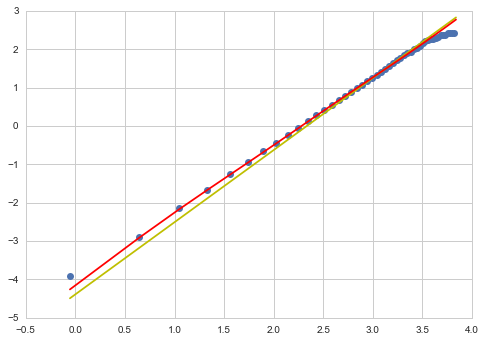

In [56]:
sample = df.speed
x = np.linspace(0, max(sample))

# 1. Plot v-p points, empirical distribution
ecdf = sm.distributions.ECDF(sample)
y = ecdf(x)
plt.plot(np.log(x), np.log(-np.log(1-y)),'o')

# 2. Weibull distribution
w_scale, c_shape = weibull_params[1], weibull_params[3]
qz=np.exp(-(x/c_shape)**w_scale)
plt.plot(np.log(x), np.log(-np.log(qz)),'-', color = 'y')

# 3. OEN3 distribution, LMSE
x, y_ = x_vals_OEN3_LMSE, y_vals_OEN3_LMSE
y = np.array(zip(*y_)[0])
plt.plot(np.log(x), np.log(-np.log(1-y)),'-', color = 'r')

plt.show()

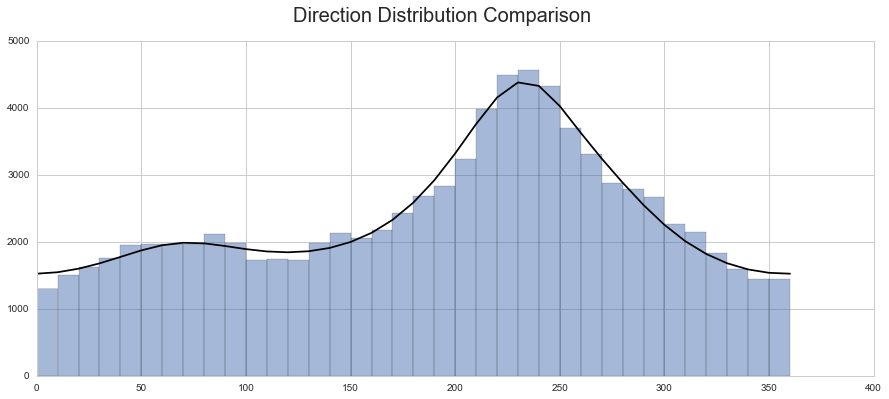

In [57]:
# Calculate Angle Distribution
x_vals = np.linspace(0,2*np.pi, num=36+1)
y_vals_ =[integrate.nquad(f, [[0, inf],[x_val-np.pi/36, x_val+np.pi/36]]) for x_val in x_vals]

# 1. integrate.nquad returns 2 vaule, result, abserr. Need to abstract the first to plot
# 2. * length of data size, to adjust the plot space
y_vals = np.array(zip(*y_vals_)[0])*len(df['dir']) 

bins=np.arange(0, 360 + 1, 10)
df['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

plt.plot(x_vals/np.pi*180, y_vals,'-', color='black')
plt.suptitle('Direction Distribution Comparison', fontsize = 20)
plt.show()

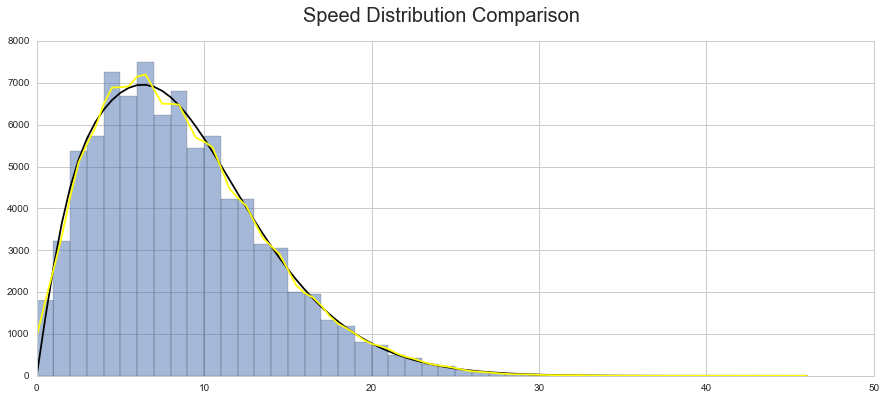

In [58]:
# Calculate Speed Distribution
# 1. GMM Model
x_vals = np.arange(0, max_speed, 0.5)
y_vals_ =[integrate.nquad(f, [[x_val-0.5, x_val+0.5],[0, 2*np.pi]]) for x_val in x_vals]
y_vals = np.array(zip(*y_vals_)[0])*len(df.speed)
plt.plot(x_vals, y_vals,'-', color='black')

# 2. Observation
bins = np.arange(0, max_speed, 1)
df['speed'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

# 3. 1d KDE
sample = np.array(df.speed).reshape(-1, 1)
kde_temp = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [np.exp(kde_temp.score_samples(x_val))*len(sample) for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

plt.suptitle('Speed Distribution Comparison', fontsize = 20)
plt.show()

In [59]:
# Calculate Speed Distribution
def model_data_comparison(df, original_sector_width = 10, incre = 10):
    start, end = original_sector_width/2 + incre/2, 360 - incre/2
    max_speed = df.speed.max()
    for angle in np.arange(start, end, incre):
        angle_radian, incre_radian = radians(angle), radians(incre)  

        # Select data from observation
        start_angle, end_angle = angle-incre/2, angle+incre/2
        sub_df= df[(df['dir'] >= start_angle) & (df['dir'] <= end_angle)] 

        # 1. Count comparison
        # 1.1. Data Count
        bins = np.arange(0, max_speed, 1)
        sub_df['speed'].hist(bins=bins, alpha=0.5,figsize=(12, 3))
        
        # 1.2. Model Count
        x_vals = np.arange(0, max_speed, 0.5)
        y_vals_ =[integrate.nquad(f, [[x_val-0.5, x_val+0.5],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x_vals]
        y_vals = np.array(zip(*y_vals_)[0])*len(df.speed)
        plt.plot(x_vals, y_vals,'-', color='black')
    
        title = str(angle) + ' (' + str(start_angle) + '-' +str(end_angle) + ')'
        plt.suptitle(title+' Degree Speed Distribution Comparison', fontsize = 15)
        plt.show()
        
        # 2. CDF, Weibull plot comparison
        # 2.1. Data's empirical distribution
        sample = sub_df.speed
        x = np.linspace(0, max(sample))
        ecdf = sm.distributions.ECDF(sample)
        y_cdf = ecdf(x)
        
        # 2.2. Model
        y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
        direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
        y_gmm = np.array(zip(*y_)[0])/direction_prob[0]
        
        # 2.3.1. Plot in ordinary axis
        plt.plot(x, y_cdf,'o')
        plt.plot(x, y_gmm,'-', color = 'r')
        plt.show()
        
        # 2.3.2. Plot in Weibull axis
        plt.plot(np.log(x), np.log(-np.log(1-y_cdf)),'o')
        plt.plot(np.log(x), np.log(-np.log(1-y_gmm)),'-', color = 'r')
        plt.show()

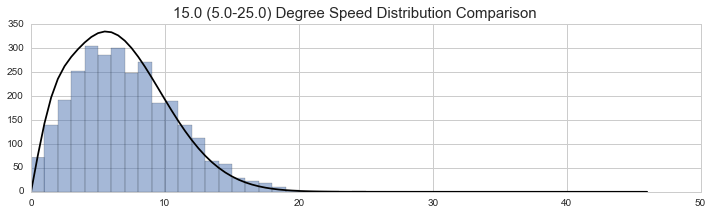

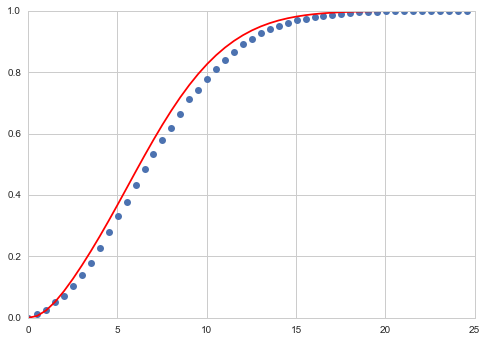

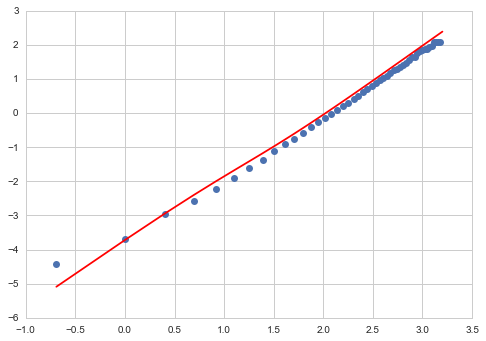

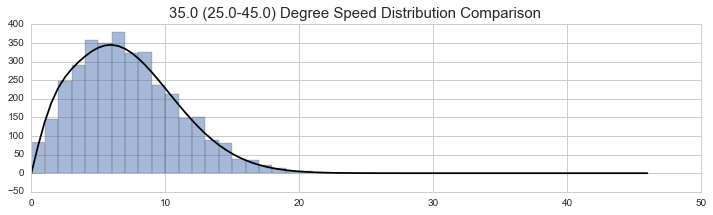

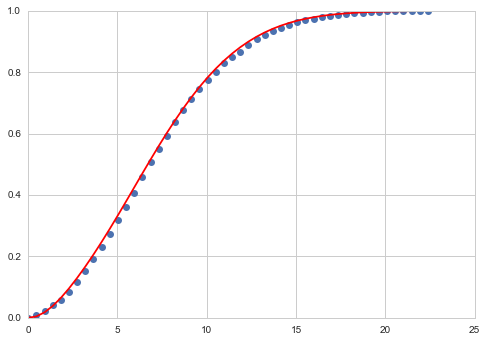

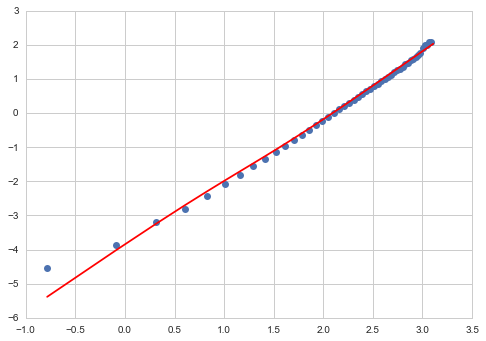

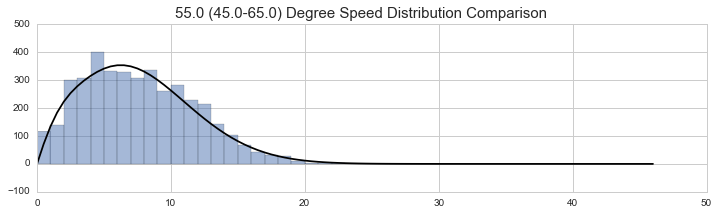

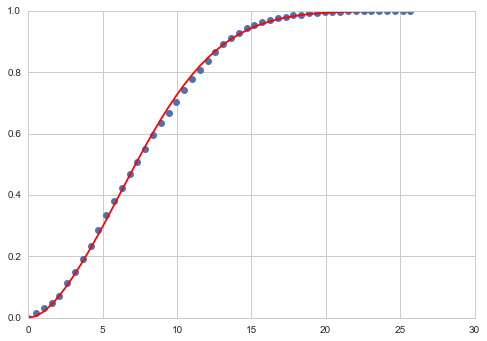

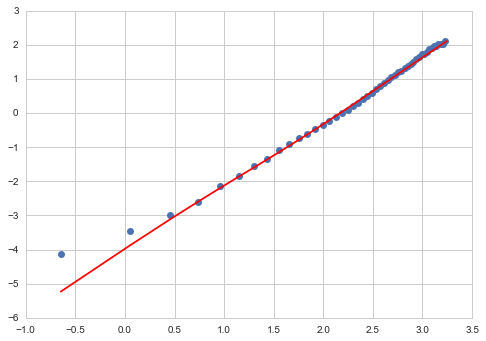

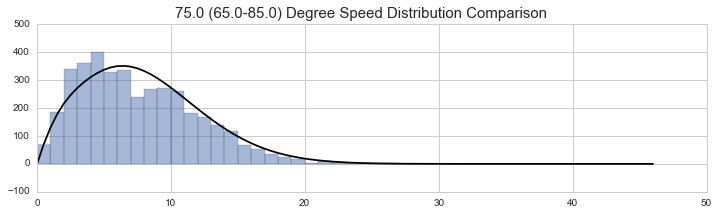

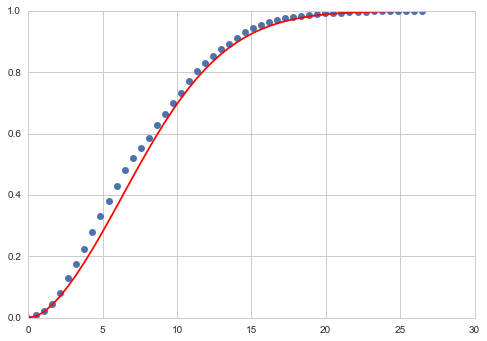

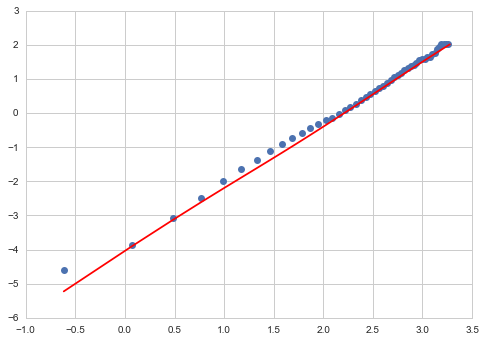

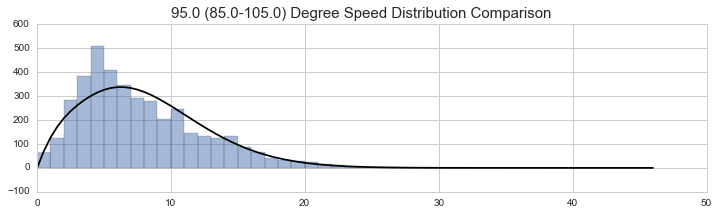

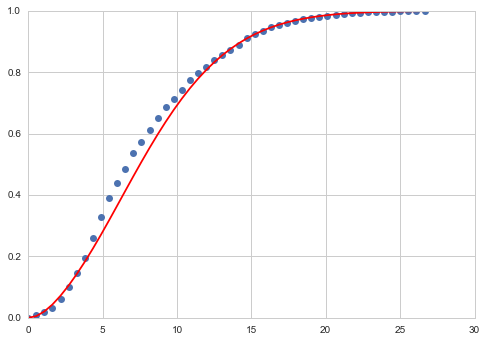

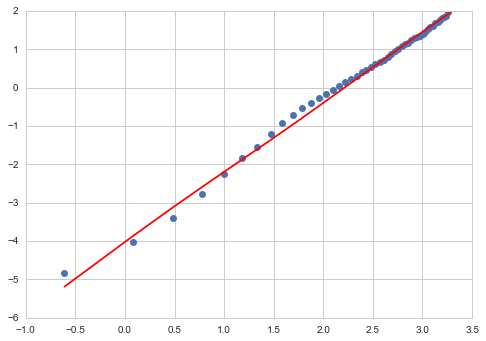

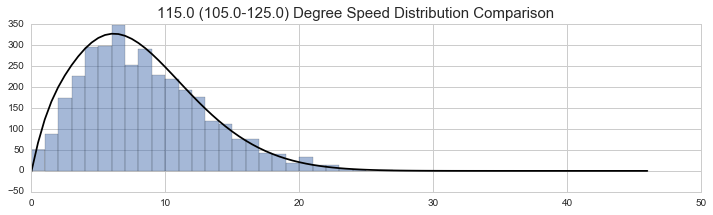

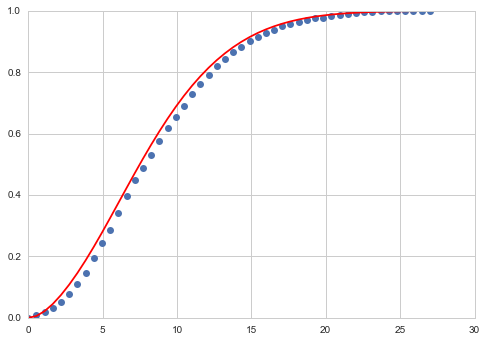

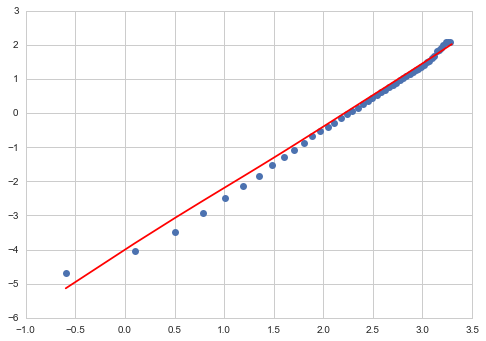

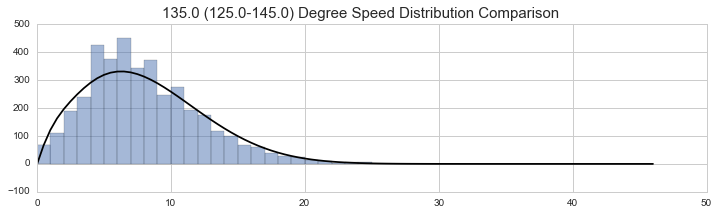

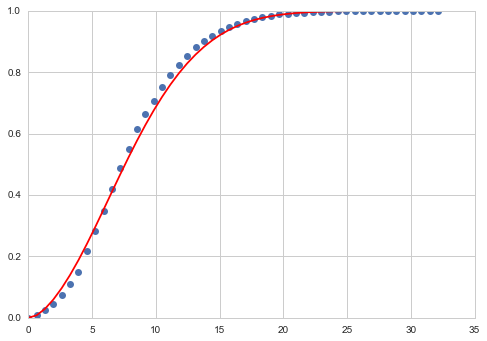

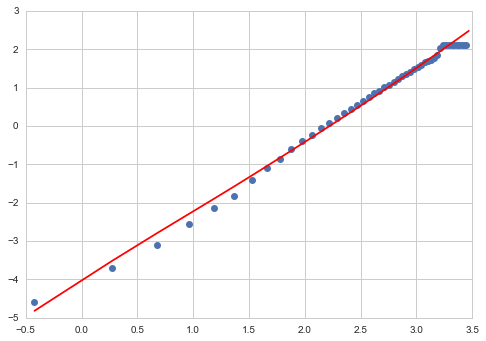

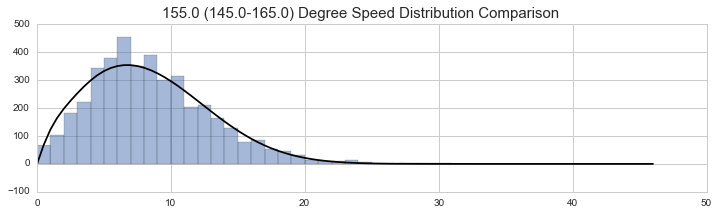

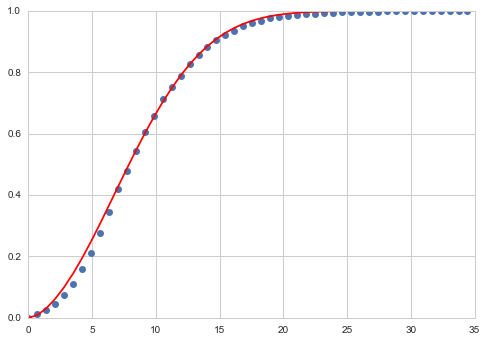

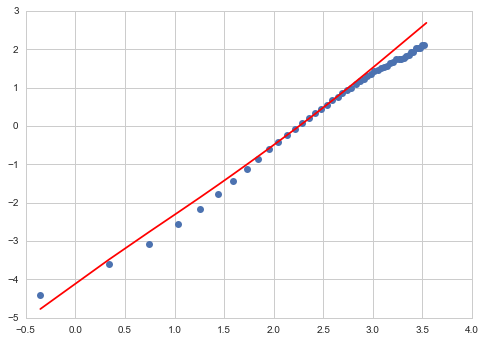

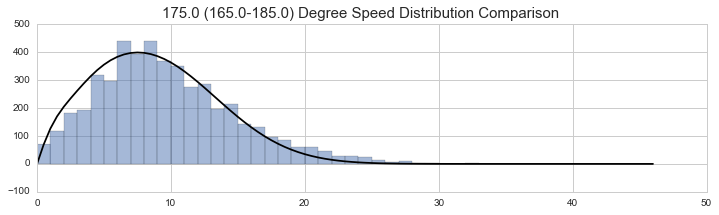

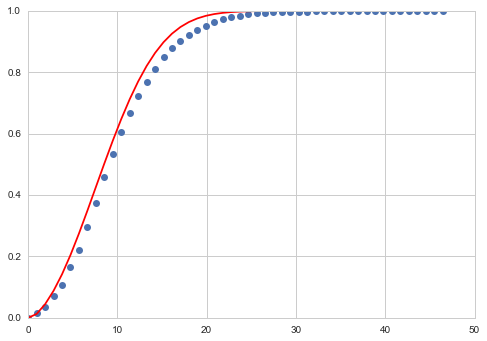

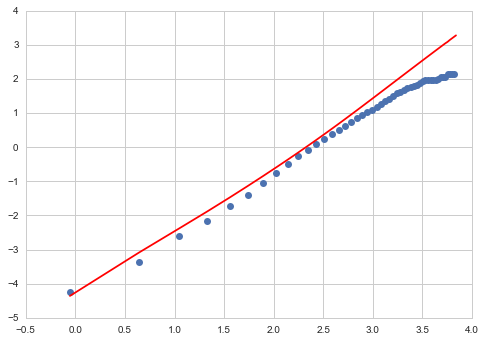

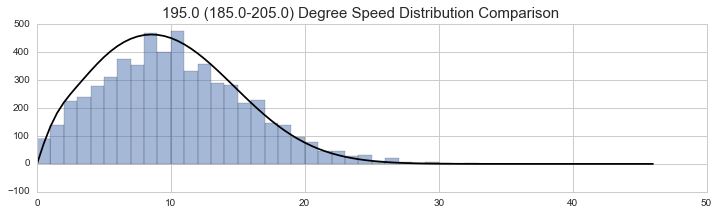

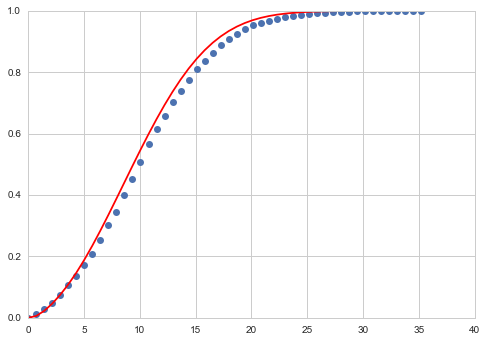

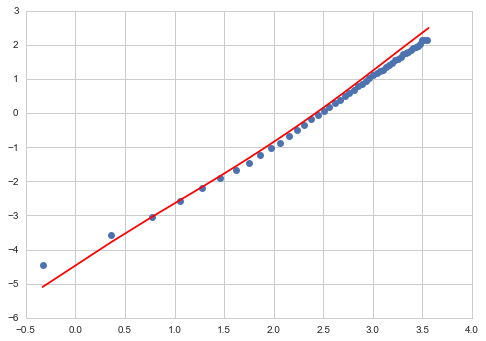

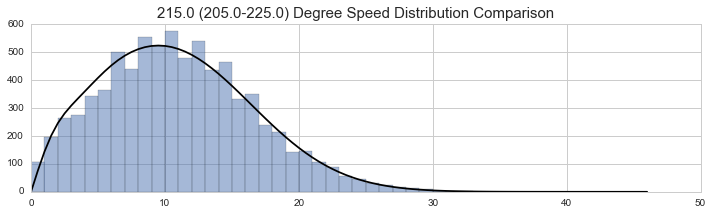

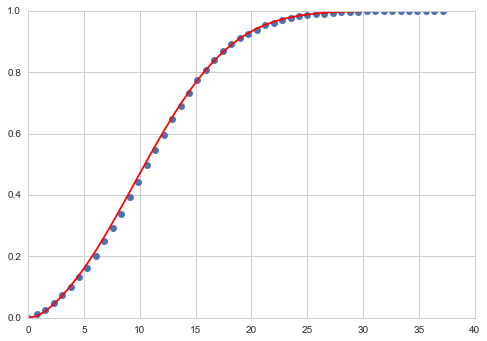

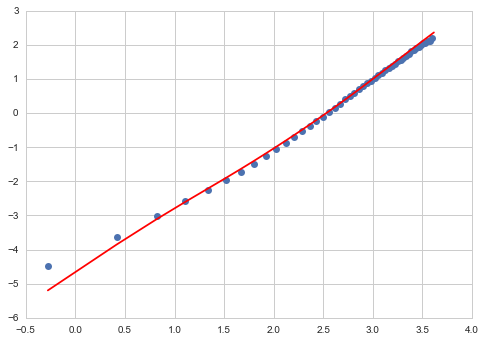

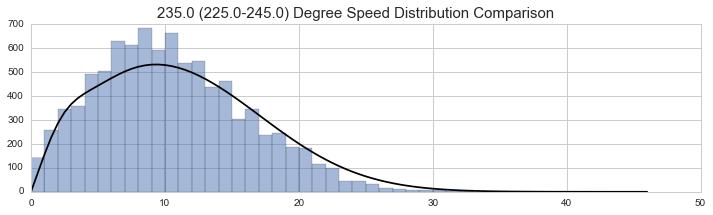

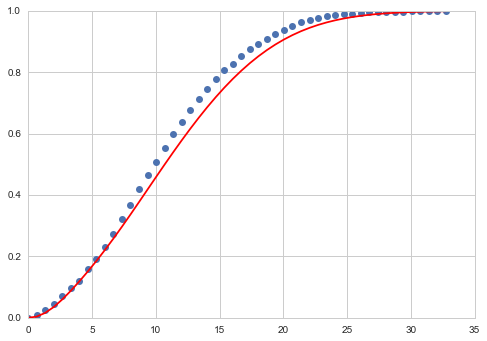

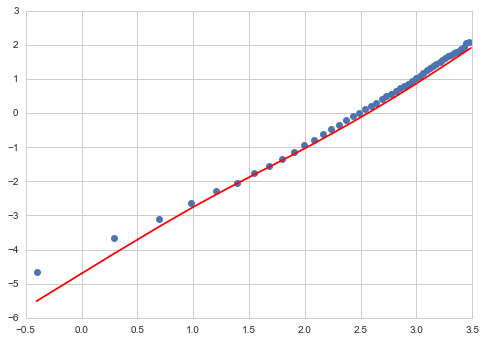

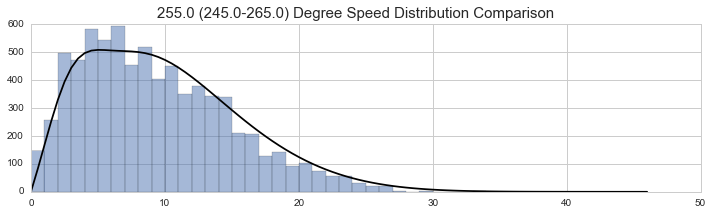

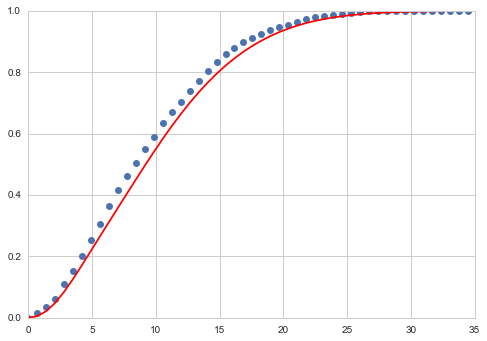

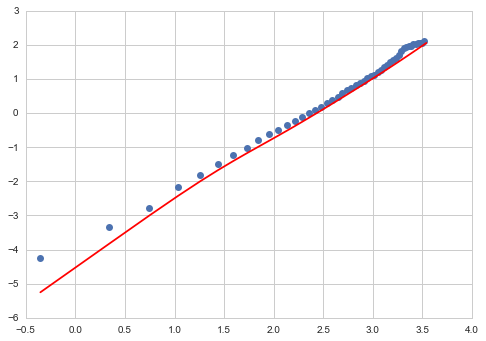

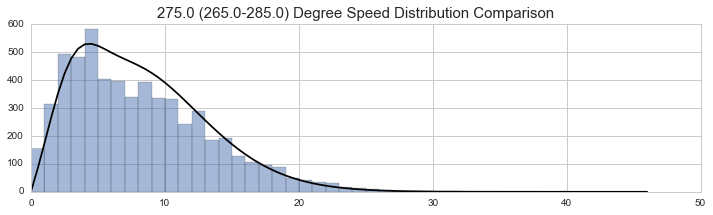

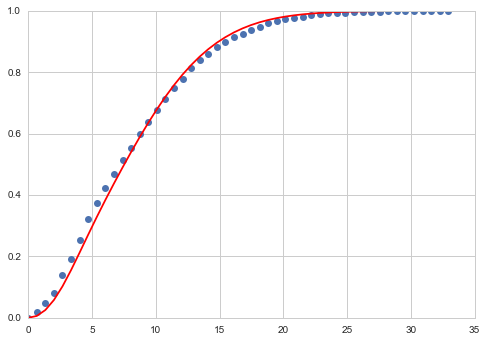

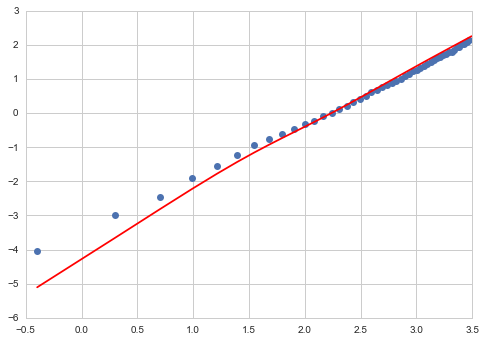

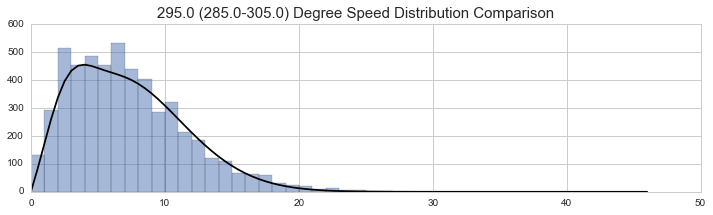

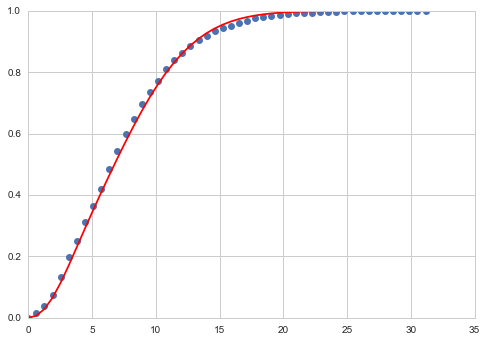

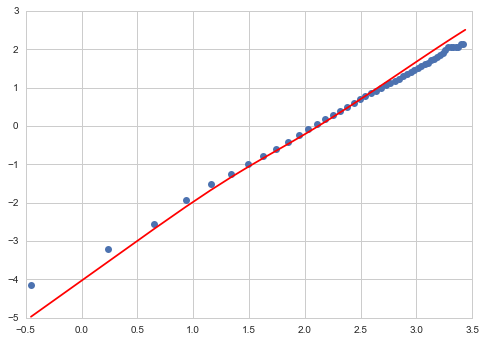

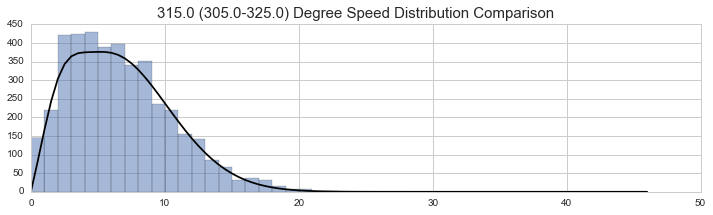

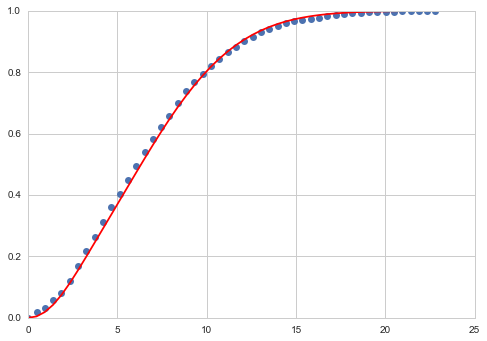

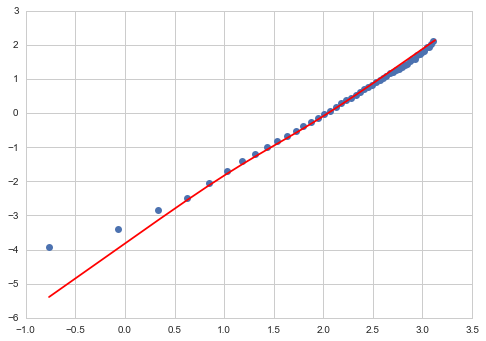

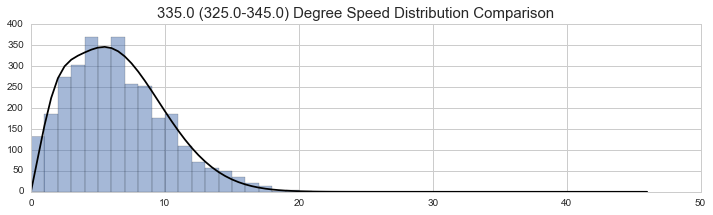

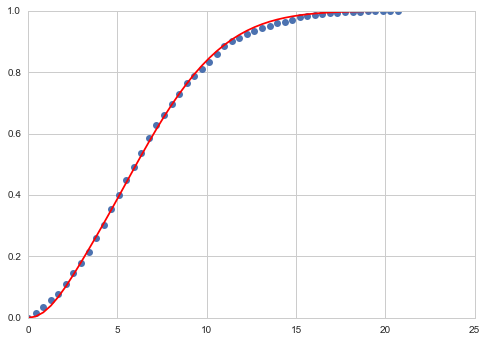

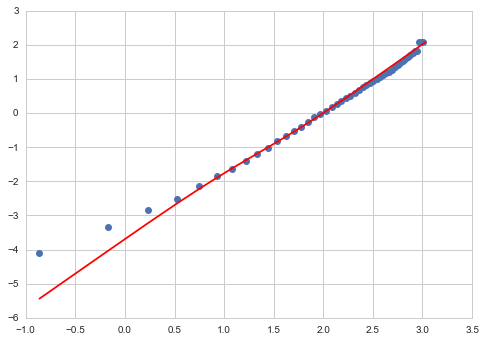

In [60]:
if cn_database:
    model_data_comparison(df, 22.5, 22.5)
else: 
    model_data_comparison(df, 10, 20)

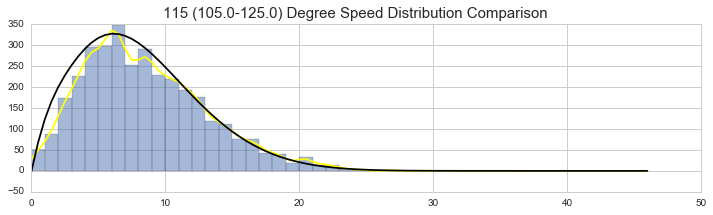

In [61]:
angle =  115
incre = 20

angle_radian, incre_radian = radians(angle), radians(incre)  
x_vals = np.arange(0, max_speed, 0.5)

# Select data from observation
start_angle, end_angle = angle-incre/2, angle+incre/2
sub_df= df[(df['dir'] >= start_angle) & (df['dir'] <= end_angle)] 
max_speed = sub_df.speed.max()

# 1. Observation
bins = np.arange(0, max_speed, 1)
sub_df['speed'].hist(bins=bins, alpha=0.5,figsize=(12, 3))

# 2. 1d KDE 
sample = np.array(sub_df.speed).reshape(-1, 1)
sub_kde = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [np.exp(sub_kde.score_samples(x_val))*len(sample) for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

# 3. GMM
y_vals_ =[integrate.nquad(f, [[x_val-0.5, x_val+0.5],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x_vals]
y_vals = np.array(zip(*y_vals_)[0])*len(df) 
plt.plot(x_vals, y_vals,'-', color='black')

title = str(angle) + ' (' + str(start_angle) + '-' +str(end_angle) + ')'
plt.suptitle(title+' Degree Speed Distribution Comparison', fontsize = 15)
plt.show()

## Bootstrap, to see the variance of each sector

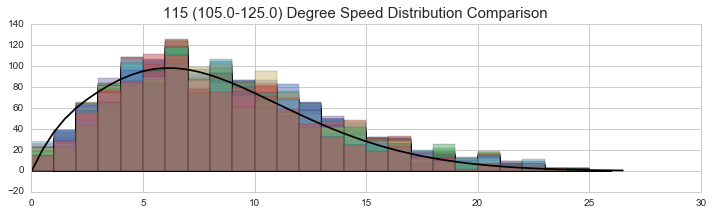

In [62]:
x_vals = np.arange(0, max_speed, 0.5)
y_vals_ =[integrate.nquad(f, [[x_val-0.5, x_val+0.5],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x_vals]
y_vals = np.array(zip(*y_vals_)[0])*len(df.speed)*0.3
plt.plot(x_vals, y_vals,'-', color='black')

bins = np.arange(0, max_speed, 1)
for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=0.3, replace=True)
    sub_df_resampled['speed'].hist(bins=bins, alpha=0.5,figsize=(12, 3))

title = str(angle) + ' (' + str(start_angle) + '-' +str(end_angle) + ')'
plt.suptitle(title+' Degree Speed Distribution Comparison', fontsize = 15)

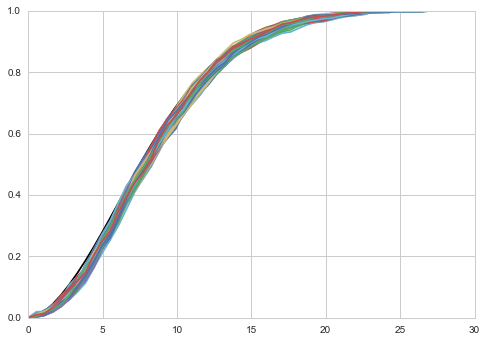

In [63]:
x = np.linspace(0, max_speed)
y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm = np.array(zip(*y_)[0])/direction_prob[0]
plt.plot(x, y_gmm,'-', color = 'black')
for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=0.3, replace=True)
    
    sample = sub_df_resampled.speed
    ecdf = sm.distributions.ECDF(sample)
    y_cdf = ecdf(x)

    plt.plot(x, y_cdf,'-')

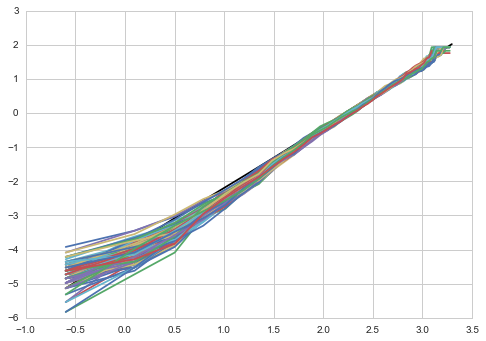

In [64]:
plt.plot(np.log(x), np.log(-np.log(1-y_gmm)),'-', color = 'black')
for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=0.3, replace=True)
    
    sample = sub_df_resampled.speed
    ecdf = sm.distributions.ECDF(sample)
    y_cdf = ecdf(x)

    plt.plot(np.log(x), np.log(-np.log(1-y_cdf)),'-')

# Cross Validation, to check the number of ellipse to be fitted

In [65]:
from sklearn.cross_validation import train_test_split, KFold
    
def fit_gmm(df, number_of_gaussian = 3, fit_method = 'square_error', print_result = False):
    # 1. Create Input, speed_set
    sample = sub_speed_set = np.array(zip(df.x, df.y))
    points = fitting_range
    
    # 2. KDE + EM fitting
    kde = neighbors.KernelDensity(bandwidth=1).fit(sample) 
    kde_result = np.exp(kde.score_samples(points))

    clf = mixture.GMM(n_components=number_of_gaussian, covariance_type='full')
    clf.fit(sample)
    gmm_em_result = read_gmm_em_result(clf, print_result)
        
    # 3. GMM fitting
    x0 = gmm_em_result
    bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)
    cons = [{'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},]
 
    result = sp.optimize.minimize(
        lambda x0: GMM_fit_score(x0, kde_result, method=fit_method),
        x0,
        bounds = bonds,
        constraints = cons,
        tol = 0.000000000001,
        options = {"maxiter": 500})  
    
    # 4. Returns
    gmm = group_gmm_param_from_gmm_param_array(result.x)       
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    gmm_pdf_result = mixed_model_pdf(points)
    
    return {
        'gmm' : gmm,
        'kde_result': kde_result,
        'gmm_pdf_result': gmm_pdf_result,
        'number_of_iteration': result.nit}

In [66]:
## 5-fold cross validation
CV_result_all =[]
print 'Number of train/test dataset', len(df)*4/5, len(df)/5

for number_of_gaussian in xrange(1,6):
    print '  '
    print 'Number of gaussian', number_of_gaussian
    
    kf = KFold(len(df), n_folds=5, shuffle=True) # each number of gaussian, fit 4 times

    CV_result = []
    for train_index, test_index in kf:
        sub_df = df.iloc[train_index]
        sub_df_test = df.iloc[test_index]

        # 1. Train
        result = fit_gmm(sub_df, number_of_gaussian, fit_method = 'square_error')
        gmm_pdf_result_train = result['gmm_pdf_result']

        # 2. Validate
        # GMM from Train - KDE from Test
        sample = np.array(zip(sub_df_test.x, sub_df_test.y))
        kde_test = neighbors.KernelDensity(bandwidth=1).fit(sample) 
        kde_result_test = np.exp(kde_test.score_samples(points))

        gof_train = goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result, 
                                            count = len(sub_df))
        gof_test =  goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_test, 
                                            count = len(sub_df_test))
        
        display(pd.DataFrame([gof_train, gof_test], index=["gof_train", "gof_test"]))
        
        CV_result.append(gof_test)
        
    CV_result_all.append(CV_result)

Number of train/test dataset 69085.6 17271.4
  
Number of gaussian 1


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,3309.406043,0.046607,6.197569e-08,0.041235,0.424333,0.920435
gof_test,947.372508,0.050398,6.119119e-08,0.042607,0.422112,0.920334


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,3310.916671,0.045851,6.186233e-08,0.041198,0.423944,0.920580
gof_test,904.785048,0.042633,5.839952e-08,0.041013,0.411901,0.924529


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,3311.333518,0.045625,6.192472e-08,0.041218,0.424158,0.920500
gof_test,925.696713,0.043096,6.075957e-08,0.041798,0.419720,0.922001


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,3309.239177,0.045833,6.195945e-08,0.041230,0.424277,0.920456
gof_test,1012.797149,0.048328,7.331049e-08,0.042944,0.461446,0.907870


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,3311.070910,0.045983,6.213234e-08,0.041287,0.424869,0.920234
gof_test,916.747388,0.047521,6.639037e-08,0.040988,0.439208,0.915765


  
Number of gaussian 2


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,1654.548268,0.005616,1.229283e-08,0.018365,0.188983,0.984218
gof_test,531.527179,0.006833,1.529145e-08,0.020159,0.210956,0.980953


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,1593.486513,0.005225,1.227303e-08,0.018350,0.188830,0.984244
gof_test,494.728210,0.003750,1.402724e-08,0.019521,0.201891,0.981702


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,1684.121280,0.006292,1.229099e-08,0.018363,0.188968,0.984221
gof_test,586.697702,0.010349,1.580081e-08,0.021583,0.214231,0.979239


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,1567.613488,0.006306,1.228041e-08,0.018355,0.188887,0.984234
gof_test,465.792044,0.008098,1.407048e-08,0.019489,0.202249,0.982145


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,1616.484771,0.005722,1.226325e-08,0.018343,0.188755,0.984256
gof_test,497.445719,0.005150,1.470241e-08,0.019961,0.206443,0.981324


  
Number of gaussian 3


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,1105.751043,0.008221,7.841392e-09,0.014667,0.150936,0.989933
gof_test,406.917424,0.014323,1.078718e-08,0.017720,0.176992,0.986068


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,910.952480,0.012159,8.730967e-09,0.015477,0.159267,0.988791
gof_test,312.759431,0.012560,1.067768e-08,0.017028,0.176405,0.986396


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,876.723373,0.012270,8.738101e-09,0.015483,0.159332,0.988782
gof_test,371.713939,0.014832,1.242371e-08,0.018177,0.190068,0.984002


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,949.615139,0.011567,8.771873e-09,0.015513,0.159640,0.988739
gof_test,336.423869,0.009321,1.075068e-08,0.016547,0.176777,0.986461


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,916.451202,0.012546,8.726140e-09,0.015473,0.159223,0.988797
gof_test,312.075922,0.012626,1.028815e-08,0.017314,0.172538,0.986731


  
Number of gaussian 4


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,1988.355473,0.013102,6.349253e-09,0.013198,0.135818,0.991849
gof_test,642.485031,0.014346,8.297295e-09,0.016088,0.155302,0.989221


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,1926.973411,0.012909,6.354435e-09,0.013204,0.135873,0.991842
gof_test,647.352182,0.014918,9.208774e-09,0.015864,0.163638,0.988289


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,1954.52053,0.012329,6.385288e-09,0.013236,0.136203,0.991802
gof_test,573.80256,0.010849,8.602581e-09,0.015400,0.158193,0.988862


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,1986.248355,0.012664,6.345882e-09,0.013195,0.135782,0.991853
gof_test,563.154831,0.011794,9.173320e-09,0.015513,0.163198,0.988561


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,2000.346631,0.012694,6.367864e-09,0.013218,0.136017,0.991825
gof_test,677.812190,0.012539,1.007207e-08,0.015984,0.170891,0.987012


  
Number of gaussian 5


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,598.52218,0.001286,2.168431e-09,0.007713,0.079372,0.997216
gof_test,249.56256,0.002405,4.990103e-09,0.011525,0.120346,0.993629


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,604.976545,0.002054,2.180880e-09,0.007735,0.0796,0.997200
gof_test,225.490268,0.006257,4.237707e-09,0.010760,0.1110,0.994652


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,599.553511,0.001769,2.171121e-09,0.007718,0.079421,0.997213
gof_test,231.559936,0.006511,4.374850e-09,0.011005,0.112801,0.994297


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,596.846602,0.001287,2.217815e-09,0.007800,0.080271,0.997153
gof_test,280.932527,0.001405,5.666435e-09,0.013272,0.128121,0.992634


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,623.976359,0.001510,2.184908e-09,0.007742,0.079673,0.997195
gof_test,274.416822,0.002263,5.246309e-09,0.011452,0.123587,0.993392


In [67]:
for idx, gof_group in enumerate(CV_result_all):
    print 'number of gaussian', idx+1
    display(pd.DataFrame(gof_group))

number of gaussian 1


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,947.372508,0.050398,6.119119e-08,0.042607,0.422112,0.920334
1,904.785048,0.042633,5.839952e-08,0.041013,0.411901,0.924529
2,925.696713,0.043096,6.075957e-08,0.041798,0.419720,0.922001
3,1012.797149,0.048328,7.331049e-08,0.042944,0.461446,0.907870
4,916.747388,0.047521,6.639037e-08,0.040988,0.439208,0.915765


number of gaussian 2


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,531.527179,0.006833,1.529145e-08,0.020159,0.210956,0.980953
1,494.728210,0.003750,1.402724e-08,0.019521,0.201891,0.981702
2,586.697702,0.010349,1.580081e-08,0.021583,0.214231,0.979239
3,465.792044,0.008098,1.407048e-08,0.019489,0.202249,0.982145
4,497.445719,0.005150,1.470241e-08,0.019961,0.206443,0.981324


number of gaussian 3


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,406.917424,0.014323,1.078718e-08,0.017720,0.176992,0.986068
1,312.759431,0.012560,1.067768e-08,0.017028,0.176405,0.986396
2,371.713939,0.014832,1.242371e-08,0.018177,0.190068,0.984002
3,336.423869,0.009321,1.075068e-08,0.016547,0.176777,0.986461
4,312.075922,0.012626,1.028815e-08,0.017314,0.172538,0.986731


number of gaussian 4


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,642.485031,0.014346,8.297295e-09,0.016088,0.155302,0.989221
1,647.352182,0.014918,9.208774e-09,0.015864,0.163638,0.988289
2,573.802560,0.010849,8.602581e-09,0.015400,0.158193,0.988862
3,563.154831,0.011794,9.173320e-09,0.015513,0.163198,0.988561
4,677.812190,0.012539,1.007207e-08,0.015984,0.170891,0.987012


number of gaussian 5


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,249.562560,0.002405,4.990103e-09,0.011525,0.120346,0.993629
1,225.490268,0.006257,4.237707e-09,0.010760,0.111000,0.994652
2,231.559936,0.006511,4.374850e-09,0.011005,0.112801,0.994297
3,280.932527,0.001405,5.666435e-09,0.013272,0.128121,0.992634
4,274.416822,0.002263,5.246309e-09,0.011452,0.123587,0.993392


In [68]:
mean_gof_all = []
for idx, gof_group in enumerate(CV_result_all):
    mean_gof = np.mean(pd.DataFrame(gof_group))
    mean_gof_all.append(mean_gof)
mean_gof_all = pd.DataFrame(mean_gof_all)
mean_gof_all

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,941.479761,0.046395,6.401023e-08,0.041870,0.430877,0.918100
1,515.238171,0.006836,1.477848e-08,0.020143,0.207154,0.981073
2,347.978117,0.012732,1.098548e-08,0.017357,0.178556,0.985932
3,620.921359,0.012889,9.070808e-09,0.015770,0.162245,0.988389
4,252.392423,0.003769,4.903081e-09,0.011603,0.119171,0.993720


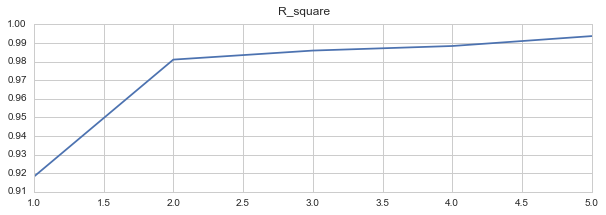

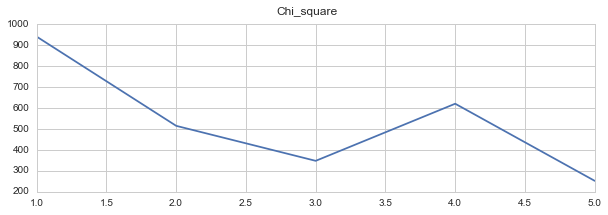

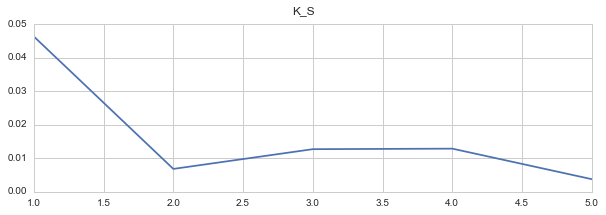

In [69]:
x = [1,2,3,4,5]
for column in ['R_square','Chi_square', 'K_S']:
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 3)
    plt.plot(x, mean_gof_all[column],'-')
    plt.suptitle(column)
    plt.show()